## Initial imports

In [1]:
import scm.plams as plams
from scm.params import ResultsImporter
from scm.plams import Settings, AMSJob, log, Molecule

# common_ru_h.py must exist in the current working directory
from common_ru_h import (
    rotation,
    dft_settings,
    QEKPointsConfig,
    lattice_optimization_settings,
    plot_pesscan,
    check_installation,
)

check_installation()

Current AMS version: 2024.102
05-31 11:12:18 m3gnet is installed: M3GNet ML Backend v[0.2.4] - build:0 [06668e0a45ce742d8f66ff23484b8a1e]
05-31 11:12:18 qe is installed: Quantum ESPRESSO (AMSPIPE) v[7.1] - build:115 [777d72eb480fe4d632a003cc62e9c1cb]


## Initialize PLAMS working directory

In [2]:
plams.init()

PLAMS working folder: /home/hellstrom/SALRuH/fix2024/plams_workdir


## Bulk structure: hcp Ru

In [3]:
initial_bulk = plams.Molecule()
a = 2.7  # hexagonal lattice parameter, angstrom
c = 4.2768  # hexagonal lattice parameter, angstrom
initial_bulk.add_atom(plams.Atom(symbol="Ru", coords=(0.0, 0.0, 0.0)))
initial_bulk.add_atom(plams.Atom(symbol="Ru", coords=(0.0, a / 3**0.5, c / 2)))
initial_bulk.lattice = [[a, 0, 0], [-a / 2, a * 3**0.5 / 2, 0], [0, 0, c]]
log("Initial structure")
log(initial_bulk)

[31.05|11:12:18] Initial structure
[31.05|11:12:18]   Atoms: 
    1        Ru       0.000000       0.000000       0.000000 
    2        Ru       0.000000       1.558846       2.138400 
  Lattice:
        2.7000000000     0.0000000000     0.0000000000
       -1.3500000000     2.3382685902     0.0000000000
        0.0000000000     0.0000000000     4.2768000000



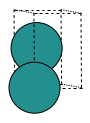

In [4]:
plams.plot_molecule(initial_bulk, rotation=rotation)

## Lattice optimization of bulk Ru with DFT

In [5]:
lattopt_job = plams.AMSJob(
    settings=dft_settings(QEKPointsConfig(11, 11, 11)) + lattice_optimization_settings(),
    name="hcp_lattopt_Ru_dft",
    molecule=initial_bulk,
)
lattopt_job.run();

[31.05|11:12:19] JOB hcp_lattopt_Ru_dft STARTED
[31.05|11:12:19] JOB hcp_lattopt_Ru_dft RUNNING
[31.05|11:12:44] JOB hcp_lattopt_Ru_dft FINISHED
[31.05|11:12:45] JOB hcp_lattopt_Ru_dft SUCCESSFUL


In [6]:
optimized_bulk: Molecule = lattopt_job.results.get_main_molecule()  # type: ignore
log(optimized_bulk)
log(f"Density: {optimized_bulk.get_density():.2f} kg/m^3")

[31.05|11:12:45]   Atoms: 
    1        Ru       0.000000       0.000000       0.000000 
    2        Ru      -0.000000       1.561640       2.136759 
  Lattice:
        2.7048396424     0.0000000000     0.0000000000
       -1.3524198212     2.3424598435     0.0000000000
        0.0000000000     0.0000000000     4.2735187675

[31.05|11:12:45] Density: 12396.59 kg/m^3


## Volume scan of bulk Ru with DFT

In [7]:
from common_ru_h import (
    dft_settings,
    QEKPointsConfig,
    pesscan_settings,
    CellVolumeScalingRangeScanCoordinate,
)

s = dft_settings(QEKPointsConfig(11, 11, 11))
s += pesscan_settings([CellVolumeScalingRangeScanCoordinate(0.85, 1.15)], n_points=7)
volume_scan_job = AMSJob(
    settings=s,
    molecule=optimized_bulk,
    name="bulk_hcp_Ru_volume_scan_dft",
)
volume_scan_job.run();

[31.05|11:12:45] JOB bulk_hcp_Ru_volume_scan_dft STARTED
[31.05|11:12:45] JOB bulk_hcp_Ru_volume_scan_dft RUNNING
[31.05|11:14:17] JOB bulk_hcp_Ru_volume_scan_dft FINISHED
[31.05|11:14:18] JOB bulk_hcp_Ru_volume_scan_dft SUCCESSFUL


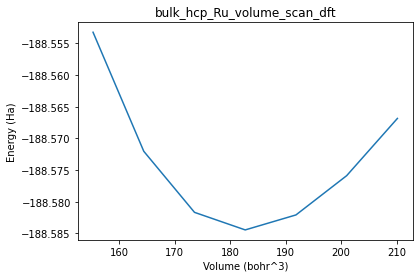

In [8]:
plot_pesscan(volume_scan_job);

## Bond scan of H2 with DFT

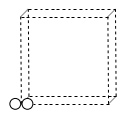

In [9]:
h2_mol = plams.from_smiles("[HH]")
h2_mol.lattice = [[5, 0, 0], [0, 5, 0], [0, 0, 5]]
plams.plot_molecule(h2_mol, rotation=rotation)

In [10]:
from common_ru_h import (
    dft_settings,
    QEKPointsConfig,
    pesscan_settings,
    DistanceScanCoordinate,
)

scan_coordinate = DistanceScanCoordinate(atom1=1, atom2=2, start=0.55, end=1.0)
s = dft_settings(QEKPointsConfig(1, 1, 1))
s += pesscan_settings([scan_coordinate], n_points=7)

h2_bond_scan_job = AMSJob(settings=s, molecule=h2_mol, name="h2_bond_scan_dft")

h2_bond_scan_job.run();

[31.05|11:14:18] JOB h2_bond_scan_dft STARTED
[31.05|11:14:18] JOB h2_bond_scan_dft RUNNING
[31.05|11:15:19] JOB h2_bond_scan_dft FINISHED
[31.05|11:15:19] Job h2_bond_scan_dft reported warnings. Please check the output
[31.05|11:15:19] JOB h2_bond_scan_dft SUCCESSFUL


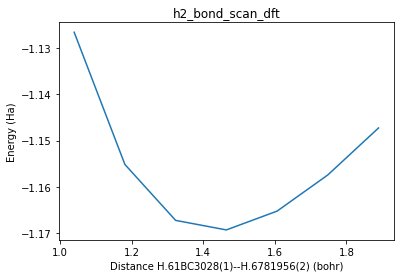

In [11]:
plot_pesscan(h2_bond_scan_job);

## Store results

In [12]:
ri = ResultsImporter.from_ase()
properties = ["energy", "forces"]
ri.add_pesscan_singlepoints(volume_scan_job, properties=properties)
ri.add_pesscan_singlepoints(h2_bond_scan_job, properties=properties)
ri.add_singlejob(lattopt_job, task="SinglePoint", properties=properties)

# Also add as PES Scans - these will not be used during training but
# will plot the energy-volume curve and bond-scan curve at the end
# of the training
ri.add_singlejob(volume_scan_job, task="PESScan", properties=["pes"])
ri.add_singlejob(h2_bond_scan_job, task="PESScan", properties=["pes"])

ri.store("reference_data_1")

['reference_data_1/job_collection.yaml',
 'reference_data_1/results_importer_settings.yaml',
 'reference_data_1/training_set.yaml']